In [1]:
import sys, os
if 'google.colab' in sys.modules:
    %cd
    % rm -rf MPyDATA
    ! git clone --recurse-submodules -j8 https://github.com/Michaeldz36/MPyDATA.git
    %cd MPyDATA
    ! git checkout develop
    ! pip install -U $(cat requirements.txt | cut -d '=' -f 1)
else:
    sys.path.append(os.path.join(os.getcwd(), '../..'))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from MPyDATA_examples.Olesik_et_al_2020.setup import Setup, default_opt_set
from MPyDATA_examples.Olesik_et_al_2020.coordinates import x_id, x_p2, x_p3, x_log_of_pn
from MPyDATA.options import Options
from MPyDATA_examples.Olesik_et_al_2020.simulation import Simulation
from MPyDATA_examples.utils.show_plot import show_plot
from joblib import Parallel, parallel_backend, delayed
from MPyDATA_examples.Olesik_et_al_2020.physics.equilibrium_drop_growth import PdfEvolver
from MPyDATA.arakawa_c.discretisation import discretised_analytical_solution
from MPyDATA_examples.utils.error_norms import L2, Smolarkiewicz_Grabowski_1990_eq21, modified_Smolarkiewicz_Rasch_r0
from MPyDATA_examples.Olesik_et_al_2020.convergence_plotter  import polar_plot
from MPyDATA_examples.Olesik_et_al_2020.analysis  import rel_disp

In [3]:
CI = 'TRAVIS' in os.environ
GCs = np.linspace(.05,.95, 4) if CI else np.linspace(.05,.95, 7)
nrs = np.array([2**n for n in (range(9, 13) if CI else range(7,15))], dtype=int)

In [4]:
grid_layout = x_p2()
psi_coord = x_p2()
setup = Setup()

In [5]:
def analysis(setup, GC, opt):
    options = Options(**opt)
    simulation = Simulation(setup, grid_layout,  psi_coord, options, GC)
    simulation.step(simulation.out_steps[-1])
    t = simulation.out_steps[-1] * simulation.dt
    rh = simulation.rh
    pdf_t = PdfEvolver(setup.pdf, setup.drdt, t)
    def pdf_arg(r):
        return pdf_t(r* rh.units).magnitude
    analytical = discretised_analytical_solution(
                simulation.rh.magnitude,
                pdf_arg, midpoint_value = True,
                r=simulation.r.magnitude
            ) * pdf_t(rh[0]).units
    numerical = simulation.n_of_r
    psi = simulation.psi
    g_factor = simulation.g_factor
    dp_dr = simulation.dp_dr

    
    maximum_numeric = np.max(numerical)
    maximum_analytic = np.max(analytical)
    measure_height = (maximum_numeric / maximum_analytic).magnitude
    
    dif = analytical-numerical
    measure_h_2 =  (1/t * np.sqrt( 1/len(dif) * dif.dot(dif))).magnitude
  
    error = np.log2(Smolarkiewicz_Grabowski_1990_eq21(numerical.magnitude, analytical.magnitude, t.magnitude))
    error_g = np.log2(Smolarkiewicz_Grabowski_1990_eq21(g_factor * psi.magnitude, g_factor * analytical.magnitude / dp_dr, t.magnitude))
    error_r0 = np.log2(modified_Smolarkiewicz_Rasch_r0(psi.magnitude, analytical.magnitude /dp_dr, t.magnitude, g_factor))
    
    return setup.nr, GC, error

In [6]:
opts =  default_opt_set.values()
   
def replace_names(opt):
    str_repl = [["'n_iters': 1","upwind"],
                ["'n_iters': 2","MPDATA-2"],
                ["'n_iters': 3","MPDATA-3"],
                ["'",""],
                [": True",""],
                ["{",""],["}",""],[",","_"],
                ["infinite gauge", "iga"],
                ["flux corrected terms", "fct"],
                ["third order terms", "tot"]]                            
    for repl in str_repl:
        opt = str(opt).replace(repl[0], repl[1])
    return opt

[Parallel(n_jobs=-2)]: Using backend ThreadingBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:   48.3s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-2)]: Done  18 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-2)]: Done  27 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-2)]: Done  49 out of  56 | elapsed:  8.5min remaining:  1.2min


upwind


[Parallel(n_jobs=-2)]: Done  56 out of  56 | elapsed: 10.5min finished
C:\Users\Michael\PycharmProjects\MPyDATA\MPyDATA_examples\Olesik_et_al_2020\../..\MPyDATA_examples\Olesik_et_al_2020\convergence_plotter.py:31: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contour(X, Y, Z, levels, colors='black', linewidth=.3)


ValueError: Unknown format code 'd' for object of type 'float'

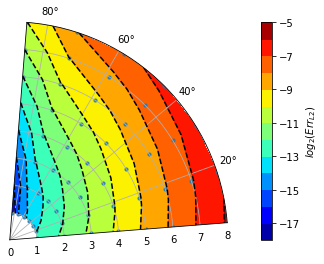

In [7]:
for opt in opts:
    with parallel_backend('threading', n_jobs=-2):
        results0 = Parallel(verbose=10)(
            delayed(analysis)(Setup(nr = nr, mixing_ratios_g_kg = [1.05,]), GC, opt)
            for nr in nrs
            for GC in GCs
        )
    results = tuple(tuple(i) for i in zip(*results0))
    plot_setup = np.array(results[0:2])
    measures = {'log$_2$(err)':results[2] ,}
    opt = replace_names(opt)
    print(opt)
    for measure in measures.keys():
        polar_plot(nrs, GCs, measures[measure], name = measure)
        show_plot(filename = f'convergence_{measure}_{opt}.pdf')